## On HMM modelling of smart home


### 1. Intro
The goal is to 1. model smart home behaviour, and 2. to identify hidden states.
We do the analysis on four states as a combination of two two-state states being ground truth and microwave. 

Specific goals for a given set of smart home data, are:
1. Determine the number of latent states (interpreted as contexts sinse they are the most influential in user behaviour)
2. Interpret the obtained states in terms of their meanings

Ad 1.: We use "goodnes of fit" to determine the best number of states

Ad 2.: We use emition matrix to interpret events

As such, we model events by preseting initial distribution (after first interpretation) and learning emition probabilities from a sequence of events. 



### 2. Findings 

#### On four observable states GT + Mw:

1. If only a single time series is given and no pre-learnd matrices, we get:
- AUC = 0.88
- number of hidden state = 4, not less.

2. Init probs are preset, transition and emition matrices are estimated from data (params='te'):
- number of optimal hidden states are periodic with a period 4. This can be a consequence number of observable states.

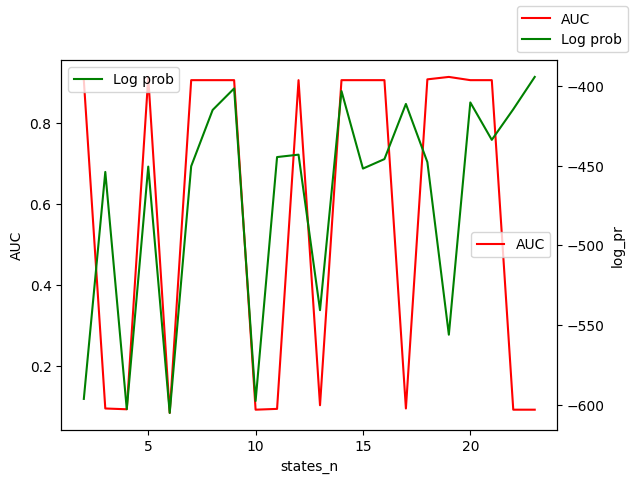
- interpretation from emition matrix




In [ ]:
# https://medium.com/analytics-vidhya/hmm-for-multidimensional-categorical-data-68b1091c9d66

In [3]:
# pip install hmmlearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from hmmlearn import hmm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from itertools import combinations
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import TimeSeriesSplit
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier

import functions_data_processing as fsd
import smart_home_tools as sht

In [4]:
# Settings
data_path = 'Data/'

In [5]:
# Branje datoteke CSV, nastavljanje visokih vrednosti na 1 in nizkih vrednosti na 0 ter izdelava novega stolpca poimenovanega "Mikrovalovna pečica - Privzeto (združeno)".

df_imported = pd.read_csv(data_path + 'df.csv', index_col=0)
#df_imported = df_imported
df_imported.index = pd.to_datetime(df_imported.index)
sigs_df = pd.DataFrame()
sigs_df["Microwave"] = df_imported["Microwave"]
sigs_df["Default"] = df_imported["Default"]
sigs_df["Ground Truth"] = df_imported["Ground Truth"]
sigs_df["GT_Mw"] = "temporary"
sigs_df["Garage door"] = df_imported["Garage door"]

sigs_df = sigs_df.mask(sigs_df == 0.9, 1)
sigs_df = sigs_df.mask(sigs_df == 0.1, 0)

mask = {}
mask['00'] = (sigs_df["Microwave"] == 0.0) & (sigs_df["Default"] == 0.0)
mask['01'] = (sigs_df["Microwave"] == 0.0) & (sigs_df["Default"] == 1.0)
mask['10'] = (sigs_df["Microwave"] == 1.0) & (sigs_df["Default"] == 0.0)
mask['11'] = (sigs_df["Microwave"] == 1.0) & (sigs_df["Default"] == 1.0)

state_vals_dc = {}
state_vals_dc['00'], state_vals_dc['01'], state_vals_dc['10'], state_vals_dc['11'] = 0, 1, 2, 3


#sigs_df["GT_Mw"] = ""
S = ['00', '01', '10', '11']
for s in S:
    sigs_df["GT_Mw"].mask(mask[s], state_vals_dc[s], inplace=True) 
    #sigs_df["GT_Mw"] = sigs_df["GT_Mw"].mask(mask[s], 0, inplace=True) 
    
sigs_df.head()

,Microwave,Default,Ground Truth,GT_Mw,Garage door
2016-01-01 05:00:00,0.0,1.0,1.0,1,0.0
2016-01-01 05:01:00,0.0,1.0,1.0,1,0.0
2016-01-01 05:02:00,0.0,1.0,1.0,1,0.0
2016-01-01 05:03:00,0.0,1.0,1.0,1,0.0
2016-01-01 05:04:00,0.0,1.0,1.0,1,0.0


array([1, 3, 0, 2], dtype=object)

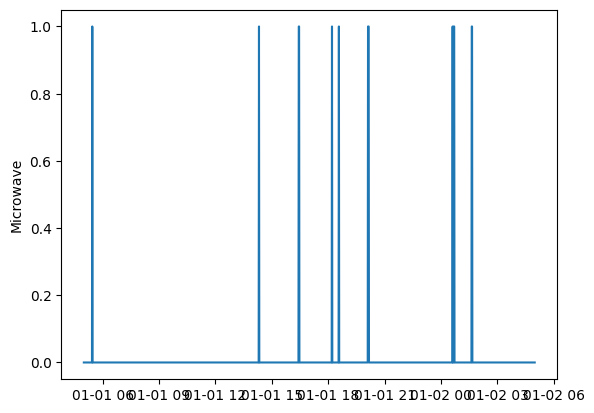

In [6]:
plt_df = sigs_df[sigs_df.index<datetime.datetime(2016, 1, 2, 5)]
sns.lineplot(data=plt_df, x=plt_df.index, y='Microwave')
sigs_df.GT_Mw.unique()

In [7]:
# Prvi teden 
df_sensors_w1 = sht.interval_model(
    data_frame=sigs_df["GT_Mw"],
    starting_date="2016-01-01 05:00:00.0",
    interval=datetime.timedelta(days=7),
)
df_sensors_w1 = df_sensors_w1.astype(int)

# Prvi teden ground truth
df_truth_w1 = sht.interval_model(
    data_frame=sigs_df['Ground Truth'],
    starting_date="2016-01-01 05:00:00.0",
    interval=datetime.timedelta(days=7),
)


# Drugi teden
df_sensors_w2 = sht.interval_model(
    data_frame=sigs_df["GT_Mw"],
    starting_date="2016-01-07 05:00:00.0",
    interval=datetime.timedelta(days=7),
)
df_sensors_w2 = df_sensors_w2.astype(int)

# Drugi teden ground truth
df_truth_w2 = sht.interval_model(
    data_frame=sigs_df["Ground Truth"],
    starting_date="2016-01-07 05:00:00.0",
    interval=datetime.timedelta(days=7),
)

In [6]:
df_sensors_w2

2016-01-07 05:00:00    1
2016-01-07 05:01:00    1
2016-01-07 05:02:00    1
2016-01-07 05:03:00    1
2016-01-07 05:04:00    1
                      ..
2016-01-14 04:56:00    1
2016-01-14 04:57:00    1
2016-01-14 04:58:00    1
2016-01-14 04:59:00    1
2016-01-14 05:00:00    1
Name: GT_Mw, Length: 10081, dtype: int32

### Week 1:

##### Goal: to identify the number of latent states and udenrstand them

In [11]:
train_pars = 'te'
startprob_prior_In = [1,0,0,0]
c_model = hmm.CategoricalHMM(n_components=4, n_iter=100, startprob_prior=startprob_prior_In, init_params=train_pars, params=train_pars)
X1 = np.array(df_sensors_w1).reshape(-1, 1)
c_model.fit(X1)

aic = c_model.aic(X1)
print (aic)


1246.1896311401686


In [21]:
# Modelling at different assumptions on week one
latent_states_n_lst = list(range(2,24))
model = {}
trans_mat = {}
emition_mat = {}


# 1. No pretrained stuffs
train_pars = 'te'
model[train_pars] = {}
trans_mat[train_pars] = {}
emition_mat[train_pars] = {}
dc_lst = []

for latent_states_n in latent_states_n_lst:

    # Start probs: on the first state
    startprob_prior_In = [1] + latent_states_n*[0]

    
    model[train_pars][latent_states_n] = hmm.CategoricalHMM(n_components=latent_states_n, n_iter=100, startprob_prior=startprob_prior_In, init_params=train_pars, params=train_pars)
    X1 = np.array(df_sensors_w1).reshape(-1, 1)
    model[train_pars][latent_states_n].fit(X1)

    predictions_prob = model[train_pars][latent_states_n].predict_proba(X1) # Posteriory probabilities on this state
    fpr, tpr, thresholds = roc_curve(np.array(df_truth_w1), predictions_prob[:,1], pos_label=1)
    auc = roc_auc_score(np.array(df_truth_w1), predictions_prob[:, 1])
    log_pr = model[train_pars][latent_states_n].score(X1)
    aic = model[train_pars][latent_states_n].aic(X1)
    bic = model[train_pars][latent_states_n].bic(X1)
    trans_mat[train_pars][latent_states_n] = model[train_pars][latent_states_n].transmat_
    emition_mat[train_pars][latent_states_n] = model[train_pars][latent_states_n].emissionprob_

    trans_P = np.round(trans_mat[train_pars][latent_states_n], 3)
    emition_P = np.round(emition_mat[train_pars][latent_states_n], 3)

    dc_lst.append({'Pars':train_pars, 'states_n': latent_states_n, 'AUC':round(auc,3), 'log_pr':round(log_pr, 3), 'AIC':round(aic, 3), 'BIC':round(bic, 3), 'trans_mat':trans_P, 'emition_mat':emition_P})

rep_df = pd.DataFrame(dc_lst)





TypeError: type method doesn't define __round__ method

In [19]:
x_df = pd.DataFrame(dc_lst)
g = sns.lineplot(data=x_df, x='states_n', y='AUC', color='r', label='AUC')
sns.lineplot(data=x_df, x='states_n', y='log_pr', color='g', ax=g.axes.twinx(), label='Log prob')
sns.lineplot(data=x_df, x='states_n', y='AIC', color='g', ax=g.axes.twinx(), label='AIC')
sns.lineplot(data=x_df, x='states_n', y='BIC', color='g', ax=g.axes.twinx(), label='BIC')


ValueError: Could not interpret value `states_n` for parameter `x`

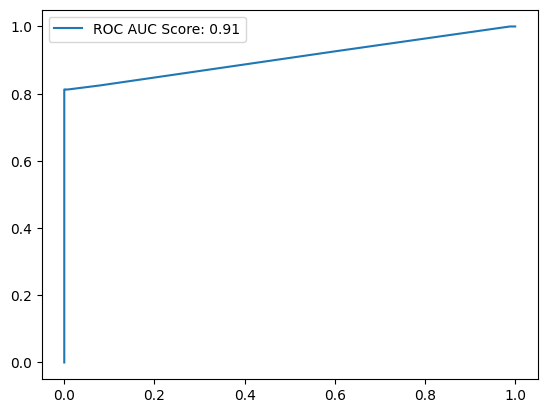

In [14]:
# Set current model
train_pars = 'te'
latent_states_n = 2
c_model = model[train_pars][latent_states_n]


# Compute ROC curve
predictions_prob = c_model.predict_proba(X1) # Posteriory probabilities on this state
predictions_stats = c_model.predict(X1) # Posteriory estimations of stated
fpr, tpr, thresholds = roc_curve(np.array(df_truth_w1), predictions_prob[:,1], pos_label=1)



plt.plot(fpr, tpr)
plt.legend(["ROC AUC Score: {:.2f}".format(roc_auc_score(np.array(df_truth_w1), predictions_prob[:, 1]))])

plt.show()


<Axes: xlabel='True_stats', ylabel='Pred_stats'>

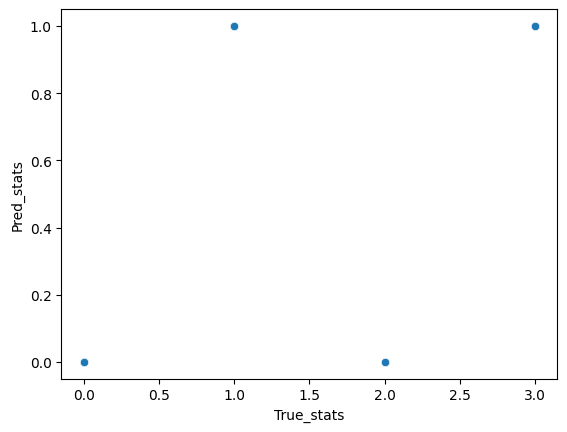

In [134]:
# Plot true ws predicted states
predictions_prob = c_model.predict_proba(X1) # Posteriory probabilities on this state
predictions_stats = c_model.predict(X1) # Posteriory estimations of stated
true_stats = X1.flatten()
X_df = pd.DataFrame()
X_df['True_stats'] = true_stats
X_df['Pred_stats'] = predictions_stats

sns.scatterplot(data=X_df, x='True_stats', y='Pred_stats')


In [ ]:
# Compute a sequence of hidden states
import numpy as np
from sklearn.utils import check_random_state
sates = model.predict(X)
transmat_cdf = np.cumsum(model.transmat_, axis=1)
random_sate = check_random_state(model.random_state)
next_state = (transmat_cdf[states[-1]] > random_state.rand()).argmax()
next_obs = model._generate_sample_from_state(next_state, random_state)

In [15]:
print(sht.compute_metrics(np.array(df_truth_w1), model.predict(X1)))

{'confusion matrix ': array([[   0, 3360],
       [5461, 1260]], dtype=int64), 'precision ': 0.2727272727272727, 'recall ': 0.1874721023657194, 'f1 ': 0.22220262763424742, 'accuracy ': 0.12498760043646463}


What if we build another model, however this time, we take the initial values for the starting, transition and emission probabilities from the learnt values from the previous model?

In [16]:
model_with_initial = hmm.CategoricalHMM(n_components=2, n_iter=100, init_params="", params="ste")
model_with_initial.startprob_ = model.startprob_
model_with_initial.transmat_ = model.transmat_
model_with_initial.emissionprob_ = model.emissionprob_
model_with_initial.fit(X1)

CategoricalHMM(init_params='', n_components=2, n_features=4, n_iter=100,
               random_state=RandomState(MT19937) at 0x1C55D226A40)

In [17]:
print("Starting probabilities\n ", model_with_initial.startprob_, "\n")
print("Transition probabilities\n ", model_with_initial.transmat_, "\n")
print("Emission probabilities\n ", model_with_initial.emissionprob_, "\n")

Starting probabilities
  [1.00000000e+00 1.00156238e-81] 

Transition probabilities
  [[0.99871795 0.00128205]
 [0.00151515 0.99848485]] 

Emission probabilities
  [[7.40091920e-22 9.87548068e-01 5.24318179e-47 1.24519319e-02]
 [9.95887446e-01 1.36901888e-18 4.11255411e-03 8.50158319e-32]] 



### Week 2

In [18]:
model2 = hmm.CategoricalHMM(n_components=2, n_iter=100, init_params="ste", params="ste")

X2 = np.array(df_sensors_w2).reshape(-1, 1)
model2.fit(X2)

CategoricalHMM(n_components=2, n_features=4, n_iter=100,
               random_state=RandomState(MT19937) at 0x1C55D226A40)

In [19]:
print("Starting probabilities\n ", model2.startprob_, "\n")
print("Transition probabilities\n ", model2.transmat_, "\n")
print("Emission probabilities\n ", model2.emissionprob_, "\n")

Starting probabilities
  [0.12564896 0.87435104] 

Transition probabilities
  [[0.0505065  0.9494935 ]
 [0.14828608 0.85171392]] 

Emission probabilities
  [[0.45200818 0.54332418 0.00206353 0.00260412]
 [0.45697482 0.53847848 0.0019715  0.0025752 ]] 



[1.87345202 0.87345202 0.86661849 0.86655944 0.86655883 0.8665528
 0.8665528  0.86617382 0.86617382 0.86597461 0.86597406 0.86597405
 0.86597399 0.86597399 0.86597043 0.86597042 0.86596855 0.86596855
 0.86596855 0.86596855 0.86596851 0.8659685  0.8659685  0.8659685
 0.8659685  0.8659685  0.8659685  0.8659685  0.8659685  0.8659685
 0.8659685  0.8659685  0.8659685  0.86596849 0.86596849 0.86596849
 0.86596849 0.86596849 0.86596836 0.86596831 0.86596798 0.86596796
 0.86596796 0.86596796 0.86596796 0.8659679  0.86594858 0.86594858
 0.86591182 0.86591182 0.86591123 0.86591117 0.86590545 0.86415083
 0.86408538 0.86408287 0.86408033 0.86406073 0.8640601  0.8640601
 0.86406008 0.86406007 0.86406007 0.86406005 0.86405986 0.86405985
 0.86405985 0.86405985 0.86405985 0.86405985 0.86405985 0.86405985
 0.86405985 0.86405985 0.86405985 0.86405985 0.86405985 0.86405985
 0.86405985 0.86405985 0.86405985 0.86405985 0.86405985 0.86405985
 0.86405985 0.86405985 0.86405985 0.86405985 0.86405985 0.86405985

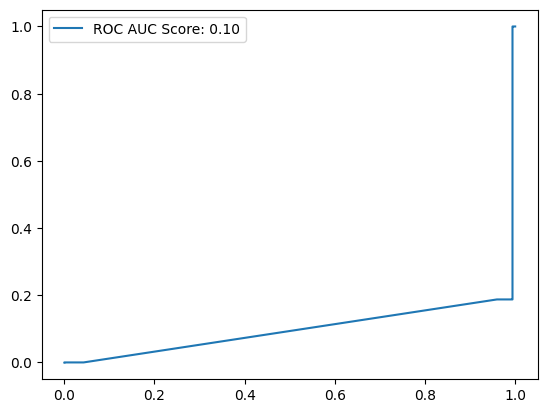

In [20]:
predictions2 = model2.predict_proba(X2)


# Compute ROC curve
fpr, tpr, thresholds = roc_curve(np.array(df_truth_w2), predictions2[:, 1], pos_label=1)

# Print fpr and tpr
# print("Fpr ", fpr)
# print("Tpr ", tpr)

print(thresholds)
plt.plot(fpr, tpr)
plt.legend(
    [
        "ROC AUC Score: {:.2f}".format(
            roc_auc_score(np.array(df_truth_w2), predictions2[:, 1])
        )
    ]
)

plt.show()

In [22]:
print(sht.compute_metrics(np.array(df_truth_w2), model2.predict(X2)))

{'confusion matrix ': array([[   0, 3360],
       [   0, 6721]], dtype=int64), 'precision ': 0.6666997321694277, 'recall ': 1.0, 'f1 ': 0.8000238066896799, 'accuracy ': 0.6666997321694277}


In [23]:
predictions[[1,3,5]][:, 0]

array([1., 1., 1.])

An important question we have is whether we will get stable results in a cross validation scenario:

Fold  0
Starting probabilities
  [9.10227794e-41 1.00000000e+00] 

Transition probabilities
  [[0.99888268 0.00111732]
 [0.00167224 0.99832776]] 

Emission probabilities
  [[2.21344417e-13 9.87712243e-01 1.06446235e-23 1.22877569e-02]
 [9.96376812e-01 1.69494700e-11 3.62318841e-03 3.68015956e-24]] 

Fold  1
Starting probabilities
  [9.66906274e-15 1.00000000e+00] 

Transition probabilities
  [[0.9983702  0.0016298 ]
 [0.00212258 0.99787742]] 

Emission probabilities
  [[7.77607791e-21 9.87662931e-01 1.66742664e-40 1.23370694e-02]
 [9.96019094e-01 2.66396447e-04 3.71450914e-03 1.23480907e-40]] 

Fold  2
Starting probabilities
  [1.00000000e+00 1.05041893e-25] 

Transition probabilities
  [[0.99862669 0.00137331]
 [0.00162382 0.99837618]] 

Emission probabilities
  [[1.24805601e-33 9.87643021e-01 9.92742036e-69 1.23569794e-02]
 [9.95669824e-01 9.41862628e-12 4.33017591e-03 3.36373409e-68]] 

Fold  3
Starting probabilities
  [1.00000000e+00 1.46799825e-74] 

Transition probabilities
  [[0

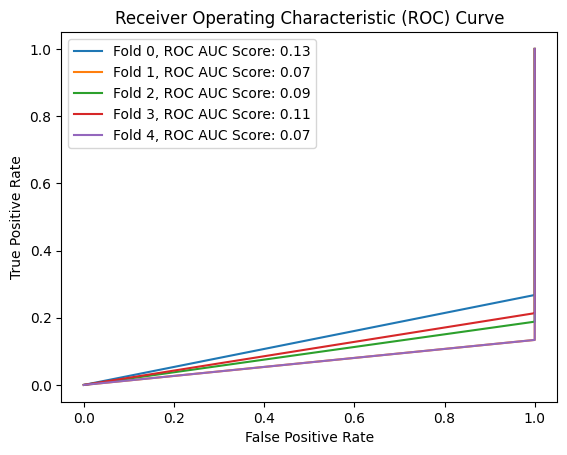

In [24]:
model_cross = hmm.CategoricalHMM(n_components=2, n_iter=100, init_params="", params="ste", random_state=105)


tscv = TimeSeriesSplit(n_splits=5, test_size=1000)
st = StratifiedKFold(n_splits=5)
legend_labels = []

for i, (train_index, test_index) in enumerate(st.split(X1, np.array(df_truth_w1))):
    print("Fold ", i)

    model_cross.fit(X1[train_index])
    print("Starting probabilities\n ", model_cross.startprob_, "\n")
    print("Transition probabilities\n ", model_cross.transmat_, "\n")
    print("Emission probabilities\n ", model_cross.emissionprob_, "\n")
    # print(compute_metrics(np.array(df_truth_w1)[test_index], model_cross.predict(X1[test_index])))

    predictions_cross = model.predict_proba(X1)[test_index]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(np.array(df_truth_w1)[test_index], predictions_cross[:, 1], pos_label=1)

    # Print fpr and tpr
    # print("Fpr ", fpr)
    # print("Tpr ", tpr)

    # print(thresholds)
    plt.plot(fpr, tpr)
    auc_score = roc_auc_score(
        np.array(df_truth_w1)[test_index], predictions_cross[:, 1]
    )
    legend_labels.append(f"Fold {i}, ROC AUC Score: {auc_score:.2f}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(legend_labels)

Perhaps we can try a supervised type approach such that we find the optimal seed for the random seed for the Dirchlet distribution in order to optimize a certain metric like accuracy, precision, f1 etc.

In [25]:
acc = []
for i in range(1, 2^32):
    model_opt = hmm.CategoricalHMM(n_components=2, n_iter=100, init_params="", params="ste", random_state=i)
    model_opt.fit(X1)
    acc.append(sht.compute_metrics(np.array(df_truth_w1), model_opt.predict(X1))["accuracy "])

c:\Users\andrejk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andrejk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
print(np.max(acc))
print(acc.index(np.max(acc)))

0.8750123995635354
9
